In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from pandas.api.types import is_numeric_dtype
from sklearn.linear_model import LinearRegression
from pprint import pprint
from sklearn.metrics import mean_squared_error


# Deliverables
1. Research Question
    - Can we predict the S&P price over the next 10 days using financial indicators?
3. Hypothesis
    - Null: There are no correlations
    - Alternative: There are correlations

In [2]:
bond_yield_df = pd.read_csv("Bond yield.csv")
cpi_df = pd.read_csv("Consumer price index.csv")
dj_df = pd.read_csv("Dow Jones.csv")
usd_eur_df = pd.read_csv("USD_EUR.csv")
usd_jpy_df = pd.read_csv("USD_JPY.csv")
gdp_df = pd.read_csv("GDP.csv")
national_hpi_df = pd.read_csv("National home price index.csv")
sp_df = pd.read_csv("S&P Price.csv")

dfs = [bond_yield_df, cpi_df, dj_df, usd_eur_df, usd_jpy_df, gdp_df, national_hpi_df, sp_df]

In [3]:
for i in range(len(dfs)):
    dfs[i].columns.values[0] = 'date'
    dfs[i] = dfs[i].drop_duplicates(subset="date", keep="first") 
    
    dfs[i].set_index('date', inplace=True)
    dfs[i].index = pd.to_datetime(dfs[i].index, errors="coerce").normalize()

    dfs[i] = dfs[i][~dfs[i].index.duplicated(keep="first")]
    


In [4]:
merged_df = pd.concat(dfs, axis=1)

In [5]:
df = merged_df[['Value', 'DJIA', 'GDP', 'DGS10', 'CSUSHPINSA', 'CPIAUCSL', 'EURO', 'JPY']]
df.columns = ['SP_price','dow_jones','gdp','bond_yield','home_price_index','consumer_price_index','eur','jpy']

df.reset_index(inplace=True)
full_date_range = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D')
df.set_index("date", inplace=True) 
df = df.reindex(full_date_range)
df.index.name = "date"

df= df.ffill()

df = df[df.index >= '1987-01-01']


In [6]:
def insert_mirrored_rows(df, num_rows=30):
    """
    Insert chronologically mirrored data point at head and tail of df
    """
    df = df.copy()
    mirrored_rows_head = df.iloc[:num_rows].copy()
    mirrored_rows_head = mirrored_rows_head.iloc[::-1].reset_index(drop=True)

    mirrored_rows_tail = df.iloc[-num_rows:].copy()
    mirrored_rows_tail = mirrored_rows_tail.iloc[::-1].reset_index(drop=True)

    df_extended = pd.concat([mirrored_rows_head, df, mirrored_rows_tail], ignore_index=True)
    
    return df_extended

In [7]:
df['SP_price_ln'] = np.log(df['SP_price'])
df['dow_jones'] = pd.to_numeric(df['dow_jones'].str.replace(',', '', regex=True))

extended_df = insert_mirrored_rows(df['SP_price'].copy(), 200)
df.dtypes

SP_price                float64
dow_jones               float64
gdp                     float64
bond_yield              float64
home_price_index        float64
consumer_price_index    float64
eur                     float64
jpy                     float64
SP_price_ln             float64
dtype: object

In [8]:
ma30_df = df.rolling(window=30).mean().reset_index().iloc[30:-30].reset_index(drop=True)
ma100_df = df.rolling(window=100).mean().reset_index().iloc[100:-100].reset_index(drop=True)
ma200_df = df.rolling(window=200).mean().reset_index().iloc[200:-200].reset_index(drop=True)
df['SP_MA_30'] = df['SP_price'].rolling(window=30).mean()
df['SP_MA_100'] = df['SP_price'].rolling(window=100).mean()
df['SP_MA_200'] = df['SP_price'].rolling(window=200).mean()


In [9]:

df.reset_index(inplace=True)  # Move the index back to a column
df.head(500)


date    SP_price  dow_jones       gdp  bond_yield  home_price_index  \
0   1987-01-01  242.712498    1895.95  4722.156        7.23            63.733   
1   1987-01-02  244.309998    1927.31  4722.156        7.18            63.733   
2   1987-01-03  244.309998    1927.31  4722.156        7.18            63.733   
3   1987-01-04  244.309998    1927.31  4722.156        7.18            63.733   
4   1987-01-05  249.415001    1971.32  4722.156        7.08            63.733   
..         ...         ...        ...       ...         ...               ...   
495 1988-05-10  257.094994    2003.65  5190.036        9.07            70.408   
496 1988-05-11  255.212502    1965.85  5190.036        9.05            70.408   
497 1988-05-12  253.837502    1968.00  5190.036        9.04            70.408   
498 1988-05-13  255.334999    1990.55  5190.036        9.00            70.408   
499 1988-05-14  255.334999    1990.55  5190.036        9.00            70.408   

     consumer_price_index     eur     jpy  SP_price_ln    SP_MA_30  \
0                   111.4  0.9107  157.47     5.491878         NaN   
1                   111.4  0.9084  158.02     5.498438         NaN   
2                   111.4  0.9084  158.02     5.498438         NaN   
3                   111.4  0.9084  158.02     5.498438         NaN   
4                   111.4  0.9149  159.13     5.519118         NaN   
..                    ...     ...     ...          ...         ...   
495                 117.5  0.8052  124.34     5.549446  261.099916   
496                 117.5  0.8054  124.46     5.542097  260.618583   
497                 117.5  0.8066  124.46     5.536694  260.055167   
498                 117.5  0.8072  124.73     5.542576  259.534333   
499                 117.5  0.8072  124.73     5.542576  259.193500   

      SP_MA_100   SP_MA_200  
0           NaN         NaN  
1           NaN         NaN  
2           NaN         NaN  
3           NaN         NaN  
4           NaN         NaN  
..          ...         ...  
495  261.685500  253.366000  
496  261.674400  253.404600  
497  261.664025  253.436325  
498  261.679100  253.523812  
499  261.713000  253.642562  

[500 rows x 13 columns]

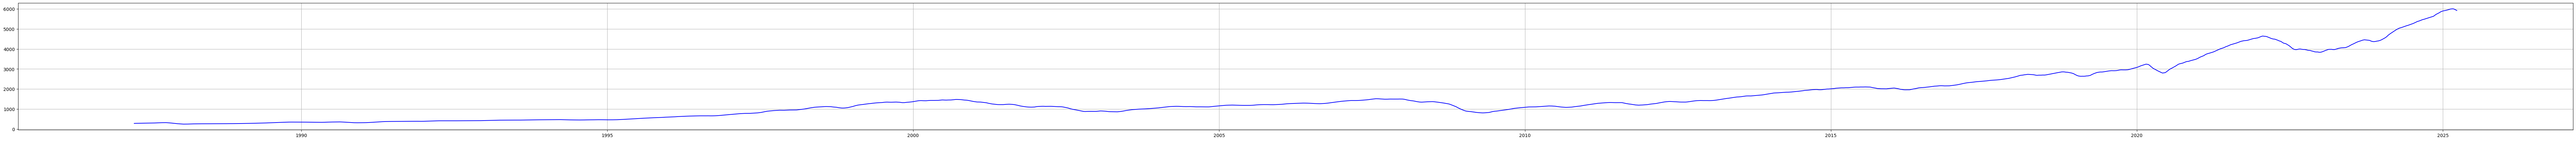

In [10]:
plt.figure(figsize=(100, 5))
plt.plot(df['date'], df['SP_MA_100'], linestyle='-', color='b', markersize=6, label="Data Line")
# Add labels and title

plt.grid(True)

plt.show()

In [11]:
df_first_of_month = df[df['date'].dt.day == 1]

## Add timeseries features
- For each daily feature, get the last 10 days for that feature

In [12]:
df['dow_jones_ln'] = np.log(df['dow_jones'])
df['gdp_ln'] = np.log(df['gdp'])
df['home_price_index_ln'] = np.log(df['home_price_index'])
df['bond_yield_ln'] = np.log(df['bond_yield'])


In [13]:
daily_features = ["SP_price_ln", "dow_jones_ln", "eur", "jpy"]

for f in daily_features:
    df[f + f"+10"] = df[f].shift(-10)
for f in daily_features:
    for i in range(1,11):
        df[f + f"-{i}"] = df[f].shift(i)
# df.iloc[35177:35187]
df.shape

(13964, 61)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13964 entries, 0 to 13963
Data columns (total 61 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  13964 non-null  datetime64[ns]
 1   SP_price              13964 non-null  float64       
 2   dow_jones             13964 non-null  float64       
 3   gdp                   13964 non-null  float64       
 4   bond_yield            13964 non-null  float64       
 5   home_price_index      13964 non-null  float64       
 6   consumer_price_index  13964 non-null  float64       
 7   eur                   13964 non-null  float64       
 8   jpy                   13964 non-null  float64       
 9   SP_price_ln           13964 non-null  float64       
 10  SP_MA_30              13935 non-null  float64       
 11  SP_MA_100             13865 non-null  float64       
 12  SP_MA_200             13765 non-null  float64       
 13  dow_jones_ln    

Intercept: 0.07980469099365362
Coefficients: [ 6.11418263e-01  1.03185858e-01  1.26124097e-01  2.86793644e-02
  1.49685702e-02  8.70756304e-02  1.57786076e-02  9.40362246e-02
  1.77677484e-02 -7.34908501e-02  5.11256972e-01 -2.16805056e-01
 -7.02144325e-02 -1.16126185e-01 -1.80317828e-02 -1.89151836e-02
 -1.58570980e-02 -8.24522134e-02 -5.26762276e-02  5.39493431e-02
 -5.81836083e-02  8.59312560e-03  6.78221985e-02  5.23388675e-02
 -3.39138822e-02 -1.99231624e-02  3.72731120e-02 -8.19503360e-03
  3.99238652e-02 -9.48907938e-02 -6.90435449e-04  2.33214632e-04
 -4.48968990e-04 -4.45905675e-07  3.17630098e-04  6.58645401e-05
  1.99575278e-04  2.20583435e-04  1.13305855e-04 -1.16681276e-04]


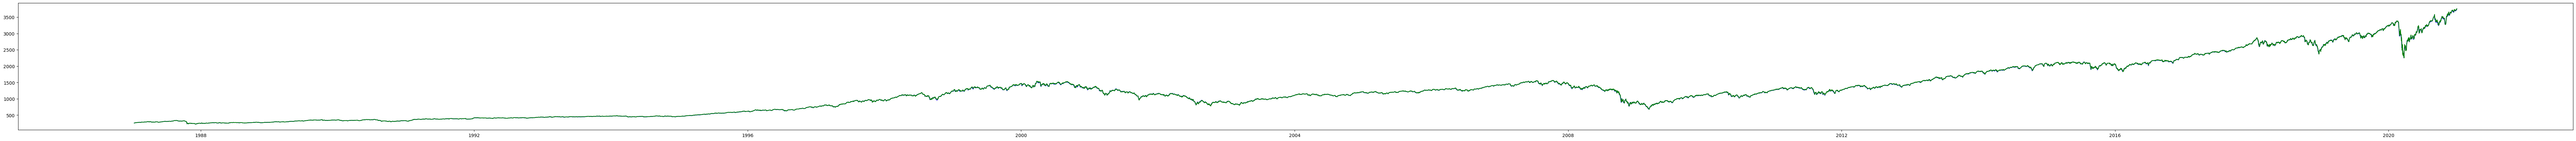

In [15]:
df_filtered = df[(df['date'].dt.year >= 1980) & (df['date'].dt.year <= 2020)]
col =  df.iloc[:, 21:].columns
df_filtered = df_filtered.dropna(subset=col)

X = df_filtered[col]
y = df_filtered['SP_price_ln+10']

model = LinearRegression()
model.fit(X, y)

print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

# Predict on new data
predictions = model.predict(X)

plt.figure(figsize=(100, 5))
plt.plot(df_filtered['date'], df_filtered['SP_price'], linestyle='-', color='b', markersize=6, label="data")
plt.plot(df_filtered['date'], math.e**predictions, linestyle='-', color='g', markersize=6, label="data")
plt.show()

In [16]:
X_new = df[df['date'] == '2020-12-31'][col]

# Make the prediction
predicted_ln = model.predict(X_new)

# Convert the log prediction back to the actual price
predicted_price = np.exp(predicted_ln)

# Print the predicted price
print(f"Predicted S&P price for 2021-01-10: {predicted_price[0]:.2f}")

value = df[df['date'] == '2020-12-31']['SP_price'].values[0]
print(f"Actual S&P price for 2021-01-10: {value}")


Predicted S&P price for 2021-01-10: 3755.52
Actual S&P price for 2021-01-10: 3756.07


In [17]:
refined = []
for i in range(len(col)):
    if model.coef_[i] > 0.02:
        refined.append(col[i])

Intercept: 0.04284665182463865
Coefficients: [ 1.09760029 -0.3400793   0.19364254 -0.11429908  0.07872989  0.09904196
  0.09966304 -0.11408045 -0.02492257  0.02636802  0.04700362 -0.06162969]


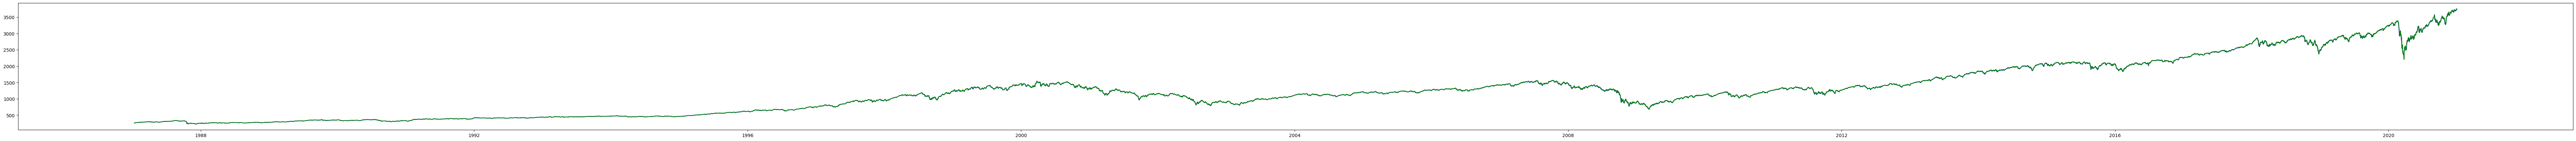

In [18]:
col =  refined
X = df_filtered[col]
y = df_filtered['SP_price_ln+10']

model = LinearRegression()
model.fit(X, y)

print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

# Predict on new data
predictions2 = model.predict(X)

plt.figure(figsize=(100, 5))
plt.plot(df_filtered['date'], df_filtered['SP_price'], linestyle='-', color='b', markersize=6, label="data")
plt.plot(df_filtered['date'], math.e**predictions2, linestyle='-', color='g', markersize=6, label="data")
plt.show()

In [19]:
X_new = df[df['date'] == '2020-12-31'][col]

# Make the prediction
predicted_ln = model.predict(X_new)

# Convert the log prediction back to the actual price
predicted_price = np.exp(predicted_ln)

# Print the predicted price
print(f"Predicted S&P price for 2021-01-10: {predicted_price[0]:.2f}")

value = df[df['date'] == '2020-12-31']['SP_price'].values[0]
print(f"Actual S&P price for 2021-01-10: {value}")


Predicted S&P price for 2021-01-10: 3747.08
Actual S&P price for 2021-01-10: 3756.07


In [20]:
df_model3 = df[(df['date'].dt.year >= 1980) & (df['date'].dt.year <= 2020)]
normalized = df_model3.copy()
scaler = StandardScaler()
y_col = "SP_price_ln"
features = normalized.drop(columns=["date",y_col,"SP_price"] + list(filter(lambda x: '+' in x, normalized.columns)))
y=df_model3[y_col]
scaled_array = scaler.fit_transform(features)
normalized = pd.DataFrame(scaled_array, index=features.index, columns=features.columns)
normalized[y_col] = y

n = len(normalized)
def adj_r2(R2, p):
    """Adjusted r^2 score from R^2, and number of features"""
    return 1-(1-R2)*(n-1)/(n-p-1)

# Model 3 (using greedy algorithm)
mod_3_scores = []
for c in normalized.columns:
    if c == y_col: continue
    model = LinearRegression(fit_intercept=True)
    
    working_df = normalized.dropna(subset=[y_col,c])
    col = working_df[c].to_numpy().reshape(-1,1)
    model.fit(col,working_df[y_col])
    score = adj_r2(model.score(col,working_df[y_col]),1)
    mod_3_scores.append((c,score))

mod_3_scores = sorted(mod_3_scores, key=lambda x: x[1],reverse=True)
print("Sorted scores for individual linear regressions:")
pprint(mod_3_scores)
print()

mod_3_score = 0
mod_3_cols = []
reg3 = LinearRegression(fit_intercept=True)
for c,_ in mod_3_scores:
    working_df = normalized.dropna(subset=mod_3_cols+[c,y_col])
    X = working_df[mod_3_cols + [c]]
    reg3.fit(X,working_df[y_col])
    score = adj_r2(reg3.score(X,working_df[y_col]),len(mod_3_cols) + 1)
    if score > mod_3_score:
        mod_3_score = score
        mod_3_cols += [c]

final_scaler = StandardScaler()

working_df = df_model3.dropna(subset=mod_3_cols + [y_col])
X3_raw = working_df[mod_3_cols]
X3_scaled = pd.DataFrame(final_scaler.fit_transform(X3_raw), columns=mod_3_cols)

reg3.fit(X3_scaled, working_df[y_col])
trained_features = mod_3_cols.copy()



Sorted scores for individual linear regressions:
[('SP_price_ln-1', 0.9998966224475738),
 ('SP_price_ln-2', 0.9997359174238573),
 ('SP_price_ln-3', 0.9995838631956306),
 ('SP_price_ln-4', 0.9994180491959811),
 ('SP_price_ln-5', 0.999253103188054),
 ('SP_price_ln-6', 0.9990941831306093),
 ('SP_price_ln-7', 0.9989391156870879),
 ('SP_price_ln-8', 0.998787888481641),
 ('SP_price_ln-9', 0.9986433954365603),
 ('SP_price_ln-10', 0.99850167211743),
 ('dow_jones_ln', 0.9931538848259938),
 ('dow_jones_ln-1', 0.993114312390673),
 ('dow_jones_ln-2', 0.9929542217566789),
 ('dow_jones_ln-3', 0.9928063810362517),
 ('dow_jones_ln-4', 0.9926319859532264),
 ('dow_jones_ln-5', 0.9924567303274893),
 ('dow_jones_ln-6', 0.9922883631291189),
 ('dow_jones_ln-7', 0.9921248553239599),
 ('dow_jones_ln-8', 0.9919590803759709),
 ('dow_jones_ln-9', 0.9917994764933332),
 ('dow_jones_ln-10', 0.9916407092633807),
 ('gdp_ln', 0.9025525266768061),
 ('dow_jones', 0.8788053964661096),
 ('SP_MA_100', 0.8766273722651212),


In [21]:
X_filtered = df[df['date'] == '2020-12-31']
X_new_raw = X_filtered[trained_features].copy()

# Fill missing columns if needed
for col in trained_features:
    if col not in X_new_raw.columns:
        X_new_raw[col] = np.nan  # or 0

X_new_scaled = pd.DataFrame(final_scaler.transform(X_new_raw), columns=trained_features)

predicted_ln = reg3.predict(X_new_scaled)
predicted_price = np.exp(predicted_ln)

print(f"Predicted S&P ln price for 2021-01-10: {predicted_ln[0]:.2f}")
print(f"Predicted S&P price for 2021-01-10: {predicted_price[0]:.2f}")

value = df[df['date'] == '2020-12-31']['SP_price'].values[0]
print(f"Actual S&P price for 2021-01-10: {value}")

print("Coefficients:", reg3.coef_)
print("Intercept:", reg3.intercept_)
print("Input features:", X_new)


Predicted S&P ln price for 2021-01-10: 8.23
Predicted S&P price for 2021-01-10: 3751.86
Actual S&P price for 2021-01-10: 3756.07
Coefficients: [ 6.44348991e-01 -8.60544636e-02  9.33896256e-02  2.49096068e-02
  1.33932962e-02  3.82592815e-01 -8.92695488e-02 -1.99373476e-01
  2.51394109e-02 -8.95464027e-02 -1.56779685e-02 -1.19009758e-02
 -6.49030278e-04  1.76299175e-04 -1.40127069e-04 -9.16752681e-04
 -1.78108207e-03  3.05862710e-03 -4.51434296e-04]
Intercept: 6.907298694550441
Input features:        SP_price_ln-1  SP_price_ln-2  SP_price_ln-3  SP_price_ln-4  \
12418        8.22471        8.22337       8.225599       8.216915   

       SP_price_ln-6  SP_price_ln-8  dow_jones_ln-1  dow_jones_ln-10   eur-3  \
12418       8.216915       8.213384       10.322512        10.316142  0.8184   

        eur-4   eur-7  eur-9  
12418  0.8191  0.8205  0.822  


In [22]:
# change window size here
#############
lookback = 20
forecast_horizon = 10
##############


feature_cols = df.iloc[:, 21:].columns

df_model = df.iloc[lookback:12054, 21:].copy()
df_model['date'] = df.iloc[lookback:12054, 0].values

target_cols = []
for step in range(1, forecast_horizon + 1):
    col_name = f'target_day_{step}'
    df_model[col_name] = df['SP_price_ln'].shift(-step + 1)
    target_cols.append(col_name)

df_model = df_model.dropna(subset=target_cols)

X = df_model[feature_cols].values
Y = df_model[target_cols].values  # shape: (n_samples, 5)

split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
Y_train, Y_test = Y[:split_idx], Y[split_idx:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression().fit(X_train_scaled, Y_train)

Y_pred = model.predict(X_test_scaled)

for i in range(forecast_horizon):
    mse = mean_squared_error(Y_test[:, i], Y_pred[:, i])
    print(f"Test MSE for day {i + 1}: {mse:.4f}")



Test MSE for day 1: 0.0000
Test MSE for day 2: 0.0001
Test MSE for day 3: 0.0001
Test MSE for day 4: 0.0001
Test MSE for day 5: 0.0002
Test MSE for day 6: 0.0002
Test MSE for day 7: 0.0003
Test MSE for day 8: 0.0003
Test MSE for day 9: 0.0003
Test MSE for day 10: 0.0004


In [23]:
# predicts future 5 days using past 10 days.
def test_predictions_leading_up(selected_date, forecast_=5, window=30):

    selected_date = pd.to_datetime(selected_date)
    
    selected_idx = df[df['date'] == selected_date].index[0]
    
    feature_values = df.iloc[selected_idx, 21:].values.reshape(1, -1)
    feature_scaled = scaler.transform(feature_values)
    
    predicted_values = model.predict(feature_scaled)[0]
    
    prediction_date_indices = [selected_idx + i for i in range(1, forecast_ + 1)]
    valid_indices = [idx for idx in prediction_date_indices if idx < len(df)]
    predicted_dates = df['date'].iloc[valid_indices]
    predicted_prices = np.exp(predicted_values[:len(valid_indices)])
    
    plot_start = max(0, selected_idx - window)
    plot_end = min(len(df), selected_idx + forecast_ + window)
    
    plt.figure(figsize=(16, 6))
    
    plt.plot(df['date'].iloc[plot_start:plot_end], df['SP_price'].iloc[plot_start:plot_end], label='Actual S&P 500', color='blue')
    
    plt.plot(predicted_dates, predicted_prices, 'ro--', label=f'Predicted price (next 5days)')
    
    plt.axvline(x=selected_date, color='green', linestyle=':', label=f'Selected Date: {selected_date.date()}')
    
    plt.title(f"price prediction from {selected_date.date()}")
    plt.xlabel('Date')
    plt.ylabel('S&P 500 Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()


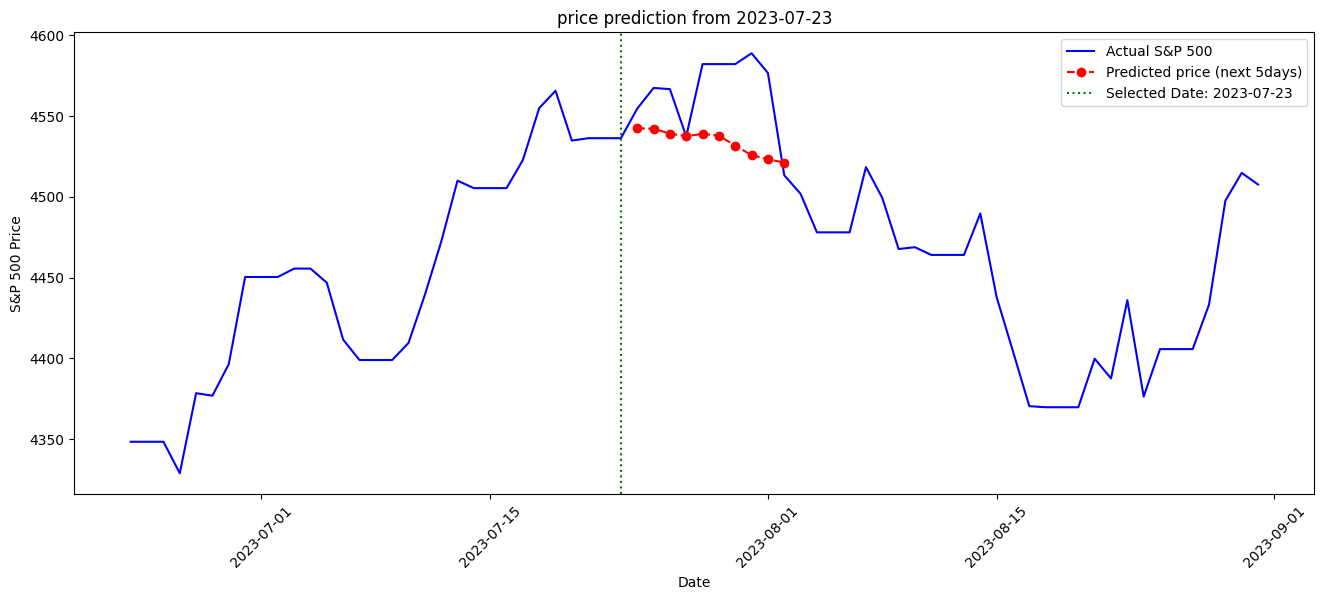

In [29]:
test_predictions_leading_up('2023-7-23', forecast_horizon)